In [72]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy.linalg import eigvalsh, qr, eigh

import matplotlib
matplotlib.rcParams['figure.figsize'] = (3.75, 3.75)
matplotlib.rcParams['figure.dpi'] = 150

from time import time
from mpire import WorkerPool
from scipy.stats import sem

import os

import koala

from koala import pointsets, voronization, graph_color, example_graphs, flux_finder, hamiltonian, graph_utils
from koala import plotting as pl
from koala.lattice import Lattice, cut_boundaries
from koala import example_graphs as eg

import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
from matplotlib.colors import ListedColormap

def plot_cmap(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    fig, ax = plt.subplots(figsize = (10,1))

    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.set_axis_off()

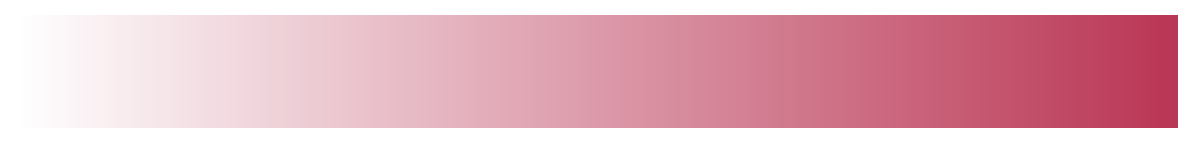

In [258]:
purple = inferno(0.5)
white = np.array([1,1,1,1])
t = np.linspace(0, 1, 256)[:, None]
newcolors = t * purple + (1-t) * white
plum_to_white_cmap = ListedColormap(newcolors)
plot_cmap(plum_to_white_cmap)

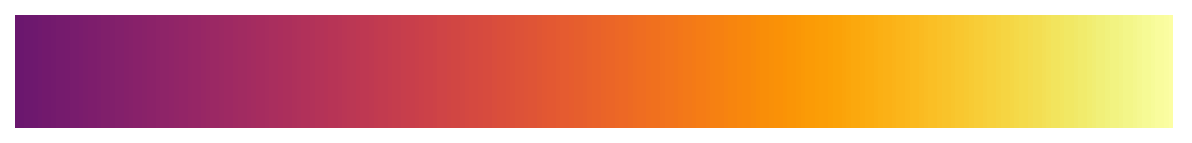

In [259]:
inferno = cm.get_cmap('inferno_r', 256)
newcolors = inferno(np.linspace(0.7, 0, 256))
white = np.array([1, 1, 1, 1])
newcolors[-1, :] = white
inferno_purple_to_white_cmap = ListedColormap(newcolors)

    
plot_cmap(inferno_purple_to_white_cmap)

Lattice(9800 vertices, 14540 edges)


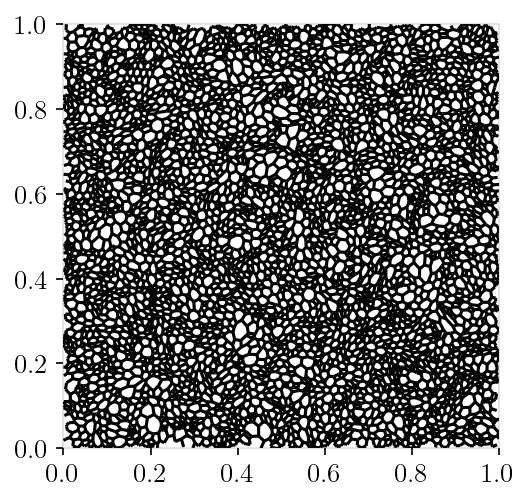

In [293]:
with open("big_solved_lattice.pickle", "rb") as f:
    d = pickle.load(f)
    globals().update(d)
    
pl.plot_edges(lattice)
print(lattice)

# lattice, coloring, gs_ujk = eg.make_amorphous(L = 20, open_boundary_conditions = True)
# lattice = cut_boundaries(lattice)

# ham = hamiltonian.generate_majorana_hamiltonian(lattice, coloring, gs_ujk, J = np.array([1, 1, 1]))
# energies, vectors = np.linalg.eigh(ham)

<AxesSubplot:>

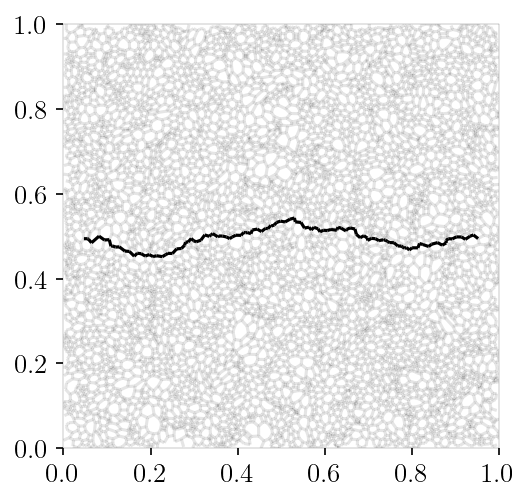

In [74]:
from koala import flux_finder
                                       
def find_transector(lattice, x = 0.5):
    points = []
    for l in [0.05,0.95]:
        dists = np.linalg.norm(lattice.vertices.positions - np.array([l, x]), axis = -1)
        m = np.argmin(dists)
        points.append(m)
    return flux_finder.path_between_vertices(lattice, points[0], points[1], early_stopping = False, maxits = 10**6)

path_verts, path_edges = find_transector(lattice)
pl.plot_edges(lattice, subset = path_edges)
pl.plot_edges(lattice, alpha = 0.1)

In [340]:
def plot_DOS_oscillations(top_ax, bottom_ax):
    data_hlm_field = np.load('dos_oscillations_hlm_field.npy', allow_pickle=True).tolist()
    data_amo_nofield = np.load('dos_oscillations_am_nofield.npy', allow_pickle=True).tolist()
    xdata = np.load('xdata.npy')
    xdata = (xdata[:-1] + xdata[1:]) / 2.0

    system_sizes = data_amo_nofield.keys()
    line_colors = [cm.inferno(X) for X in [0.25, 0.5, 0.75]]
    
    for ax in [top_ax, bottom_ax]:
        ax.set(xscale = "log", yticks = [1.00, 1.25, 1.50, 1.75])
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()

        
    top_ax.set(xticks = [])
    top_ax.axes.xaxis.set_visible(False)
    
    bottom_ax.set(xlabel = r"$E$")

    for system_size, line_color in zip(system_sizes, line_colors):
      shared_args = {
        'c': line_color,
        'alpha': 0.7,
        'fmt': '.',
        'capsize': 2,
        'markersize': 2
      }

      hlm_vals = data_hlm_field[system_size]
      amo_vals = data_amo_nofield[system_size]

      top_ax.errorbar(
        xdata, hlm_vals[0], hlm_vals[1], label=f"$L={system_size}$", **shared_args
      )

      bottom_ax.errorbar(
        xdata, amo_vals[0], amo_vals[1], **shared_args
      )

    top_ax.legend(frameon = False, borderpad = 0.0, borderaxespad = 0.4, handletextpad = 0.2)

Edge state energy = -6.891464768079127e-17


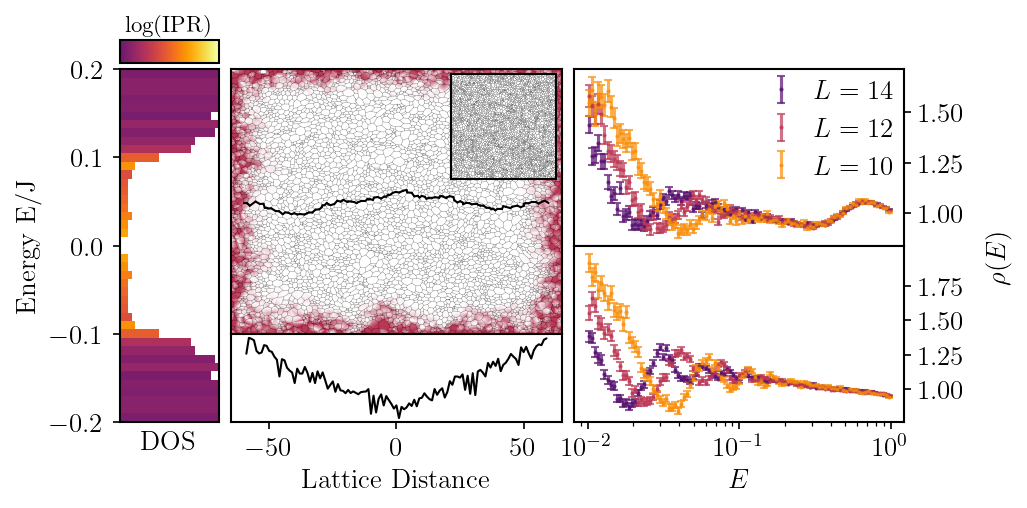

In [363]:
DOS, E_bins = np.histogram(energies, bins = 300)
IPR, _, _ = scipy.stats.binned_statistic(energies, raw_IPR, statistic='mean', bins = E_bins)

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patheffects as path_effects #https://stackoverflow.com/questions/11578760/matplotlib-control-capstyle-of-line-collection-large-number-of-lines

w = 3.375
rasterize = True #whether to rasterize some parts of the plots

matplotlib.rcParams.update({'font.size': 13, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern']})
matplotlib.rcParams.update({"axes.linewidth": 1})

## Set up the figure and the top level gridspec
fig = plt.figure(figsize = (2 * w, w))
gs = gridspec.GridSpec(nrows = 2, ncols = 3, figure=fig, 
                       height_ratios = (1,15), width_ratios = (0.3,1,1), 
                       wspace = 0.05, hspace = 0.03)

## set up left panel
DOS_ax  = fig.add_subplot(gs[1, 0])
DOS_colorbar_ax = fig.add_subplot(gs[0, 0])

## set up middle panel
middle_panel = gs[1, 1].subgridspec(nrows = 2, ncols = 1, height_ratios = (3,1), hspace = 0)
edge_mode_ax, edge_slice_ax = fig.add_subplot(middle_panel[0]), fig.add_subplot(middle_panel[1])

chern_inset_ax = inset_axes(edge_mode_ax, width=0.7, height=0.7, loc = 1, borderpad = 0.2)
chern_inset_ax.set(xticks = [], yticks = [])

## set up right panel
right_panel = gs[1, 2].subgridspec(nrows = 2, ncols = 1, hspace = 0)
# right_panel.update(left=0.1)
top_ax, bottom_ax = fig.add_subplot(right_panel[0]), fig.add_subplot(right_panel[1])

### DOS plot

ax = DOS_ax
cmap = inferno_purple_to_white_cmap
color_val = np.log(IPR)
color_val = (color_val - np.min(color_val)) / (np.max(color_val) - np.min(color_val))
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 0.6)
IPR_color = cmap(norm(color_val))

ax.set(ylabel = "Energy E/J", xlabel = "DOS", xticks = [], xlim = (0,25), ylim = (-0.2, 0.2))
ax.barh(E_bins[:-1], DOS, height = np.diff(E_bins), align = "edge", color = IPR_color, zorder = -1)
if rasterize: ax.set_rasterization_zorder(0)
print(f"Edge state energy = {energies[edge_state_i]}")
# ax.hist(energies, bins = 100, orientation = 'horizontal')

ax = DOS_colorbar_ax
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation = "horizontal")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.set_xlabel("log(IPR)", fontsize=11)
ax.set(xticks = [])

### Main edge mode plot
ax = edge_mode_ax
pl.plot_edges(lattice, linewidth = 0.2, ax = ax, zorder = -1, alpha = 0.5)
pl.plot_edges(lattice, subset = path_edges, linewidth = 1, ax = ax)
ax.tripcolor(*lattice.vertices.positions.T, edge_state_density,
             cmap = plum_to_white_cmap, shading = 'gouraud', vmin = 0.001, vmax = 0.01, zorder = -2)

if rasterize: ax.set_rasterization_zorder(0)


p = 0.01
ax.set(xticks = [], yticks = [], xlim = [p,1-p], ylim = [p,1-p])

### Edge mode line cut
ax = edge_slice_ax
n_steps = len(path_verts)
x = x = np.arange(n_steps) - n_steps//2
ax.plot(x, np.log(edge_state_density)[path_verts], linewidth = 1, color = 'k', solid_capstyle='round')
ax.set(yticks = [], xlabel = "Lattice Distance")

### Inset Chern Marker Plot
ax = chern_inset_ax
pl.plot_edges(lattice, ax = chern_inset_ax, linewidth = 0.1, zorder = -1)
if rasterize: ax.set_rasterization_zorder(0)

### Right panel: DOS Oscillations
plot_DOS_oscillations(top_ax, bottom_ax)
fig.text(0.98, 0.45, r"$\rho(E)$", va='center', rotation='vertical')

fig.savefig("fig_3.pdf",  dpi=400)